In [1]:
import pygame
import numpy as np
import math
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.3, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import pygame
import math
import numpy as np


class Environment:
    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode((800, 500))  # Field size
        pygame.display.set_caption("Reinforcement Learning: Car and Ball")
        self.clock = pygame.time.Clock()

        # Load images
        self.car_image = pygame.image.load("car.png")
        self.ball_image = pygame.image.load("ball.png")
        self.goal_image = pygame.image.load("goal.png")
        self.background_image = pygame.image.load("field.jpg")  # Background

        # Scale images
        self.car_image = pygame.transform.scale(self.car_image, (40, 50))  # Larger car
        self.ball_image = pygame.transform.scale(self.ball_image, (30, 30))  # Larger ball
        self.goal_image = pygame.transform.scale(self.goal_image, (200, 100))  # Larger goal
        self.background_image = pygame.transform.scale(self.background_image, (800, 500))

        # Goal position fixed on one side
        self.goal_x, self.goal_y = 727, 218  # Right-center goal


        # For tracking metrics
        self.episode = 0
        self.max_reward = float('-inf')
        self.current_reward = 0

        self.reset()

    def reset(self):
        self.car_x, self.car_y, self.car_angle = self.randomize_car()
        self.ball_x, self.ball_y = self.randomize_ball()
        self.car_velocity = 0
        self.car_angular_velocity = 0
        self.ball_velocity_x = 0
        self.ball_velocity_y = 0
        self.kicked = False  # Track whether the ball has been kicked
        self.goal_scored = False  # Track if the ball has entered the goal
        self.current_reward = 0  # Reset current episode's reward

        self.prev_car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        return self.get_state()

    def randomize_car(self):
        x = np.random.randint(300, 500)  # Closer to the ball
        y = np.random.randint(150, 350)
        angle = np.random.uniform(0, 360)
        return x, y, angle

    def randomize_ball(self):
        x = np.random.randint(250, 550)  # Closer to the car
        y = np.random.randint(150, 350)
        return x, y

    def get_distance(self, x1, y1, x2, y2):
        return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    def get_state(self):
        car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        return np.array([
            self.car_x, self.car_y, self.car_velocity, self.car_angular_velocity, self.car_angle,
            self.ball_x, self.ball_y, car_ball_dist, 1 if self.ball_x < self.car_x else -1
        ])

    def handle_collisions(self):
        # Ball-wall collision
        if self.ball_x - 35 < 0 or self.ball_x + 35 > 800:
            self.ball_velocity_x = -self.ball_velocity_x
        if self.ball_y - 35 < 0 or self.ball_y + 35 > 500:
            self.ball_velocity_y = -self.ball_velocity_y

    def move_car(self, action):
        if self.kicked:  # Stop the car after a kick
            self.car_velocity = 0
            self.car_angular_velocity = 0
            return

        car_speed = 5
        car_angular_speed = 5

        if action == 0:  # Forward
            self.car_velocity = car_speed
        elif action == 1:  # Backward
            self.car_velocity = -car_speed
        elif action == 2:  # Rotate Left
            self.car_angular_velocity = -car_angular_speed
        elif action == 3:  # Rotate Right
            self.car_angular_velocity = car_angular_speed
        elif action == 4:  # Forward + Left
            self.car_velocity = car_speed
            self.car_angular_velocity = -car_angular_speed
        elif action == 5:  # Forward + Right
            self.car_velocity = car_speed
            self.car_angular_velocity = car_angular_speed
        elif action == 6:  # Backward + Left
            self.car_velocity = -car_speed
            self.car_angular_velocity = -car_angular_speed
        elif action == 7:  # Backward + Right
            self.car_velocity = -car_speed
            self.car_angular_velocity = car_angular_speed
        else:  # No action
            self.car_velocity = 0
            self.car_angular_velocity = 0

        self.car_angle += self.car_angular_velocity
        self.car_x += math.cos(math.radians(self.car_angle)) * self.car_velocity
        self.car_y += math.sin(math.radians(self.car_angle)) * self.car_velocity

    def move_ball(self):
        self.ball_x += self.ball_velocity_x
        self.ball_y += self.ball_velocity_y
        self.ball_velocity_x *= 0.98  # Friction
        self.ball_velocity_y *= 0.98  # Friction

    def calculate_reward(self):
        if not self.kicked:
            car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
            if car_ball_dist <= 35 + 50:  # Ball radius + car half-width
                return 0
            return -10

        goal_dist = self.get_distance(self.ball_x, self.ball_y, self.goal_x, self.goal_y)

        if goal_dist <= 40:  # Ball touches the goal
            return 1000

        if goal_dist <= 150:
            return 500
        elif goal_dist <= 300:
            return 100
        else:
            return -50

    def check_ball_stopped(self):
        return abs(self.ball_velocity_x) < 0.1 and abs(self.ball_velocity_y) < 0.1

    def step(self, action):
        # Move car and ball
        self.move_car(action)
        self.move_ball()

        # Handle collisions
        self.handle_collisions()

        # Check if ball is kicked
        car_ball_dist = self.get_distance(self.car_x, self.car_y, self.ball_x, self.ball_y)
        if car_ball_dist <= 35 + 50 and not self.kicked:  # Ball radius + car half-width
            self.kicked = True
            angle = math.atan2(self.ball_y - self.car_y, self.ball_x - self.car_x)
            self.ball_velocity_x = math.cos(angle) * 7
            self.ball_velocity_y = math.sin(angle) * 7

        # Calculate reward
        reward = self.calculate_reward()
        self.current_reward += reward  # Track current episode reward
        self.max_reward = max(self.max_reward, self.current_reward)  # Update max reward

        # Check if the episode is done
        done = self.kicked and self.check_ball_stopped()

        # Get the next state
        next_state = self.get_state()

        return next_state, reward, done

    def render(self):
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()

        # Draw background
        self.screen.blit(self.background_image, (0, 0))

        # Rotate the goalpost to the right
        rotated_goal = pygame.transform.rotate(self.goal_image, -90)  # Rotate 90° clockwise
        self.screen.blit(rotated_goal, (self.goal_x - 50, self.goal_y - 75))  # Adjust position

        # Draw ball
        self.screen.blit(self.ball_image, (self.ball_x - 35, self.ball_y - 30))

        # Draw car
        rotated_car = pygame.transform.rotate(self.car_image, -self.car_angle)
        car_rect = rotated_car.get_rect(center=(self.car_x, self.car_y))
        self.screen.blit(rotated_car, car_rect.topleft)

        # Render labels for metrics
        font = pygame.font.SysFont(None, 24)
        episode_label = font.render(f"Episode: {self.episode}", True, (255, 255, 255))
        max_reward_label = font.render(f"Max Reward: {self.max_reward:.2f}", True, (255, 255, 255))
        current_reward_label = font.render(f"Current Reward: {self.current_reward:.2f}", True, (255, 255, 255))

        # Position and draw labels
        self.screen.blit(episode_label, (10, 10))
        self.screen.blit(max_reward_label, (10, 40))
        self.screen.blit(current_reward_label, (10, 70))

        pygame.display.flip()
        self.clock.tick(60)

In [3]:
# Deep Q-Network Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state, verbose=0)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state, verbose=0)[0])
            target_f = self.model.predict(state, verbose=0)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [ ]:
def test_dqn(saved_model,episodes=10):
    env = Environment()
    state_size = 9
    action_size = 8
    agent = DQNAgent(state_size, action_size)
    agent.model.load_weights(saved_model)
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        done = False
        total_reward = 0
        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            state = next_state
            total_reward += reward
            env.render()
        print(f"Episode: {episode + 1}, Reward: {total_reward:.2f}")
    pygame.quit()

test_dqn("dqn_model_episode_500.h5",episodes=10)

Episode: 1, Reward: -22280.00
Episode: 2, Reward: -9800.00
Episode: 3, Reward: -10200.00
Episode: 4, Reward: -211780.00
Episode: 5, Reward: -10550.00


error: display Surface quit

: 

In [4]:
def train_dqn(episodes=500, render_interval=10):
    env = Environment()
    state_size = 9  # Updated to match the size of the state array
    action_size = 8  # Number of actions
    agent = DQNAgent(state_size, action_size)
    batch_size = 32

    # Tracking metrics
    rewards = []
    kicks = []
    goals = []
    avg_distances = []

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])  # Updated to match the new state size
        total_reward = 0
        kicked = False
        goal = False
        episode_kicks = 0
        total_distance = 0
        step_count = 0

        for time in range(500):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])  # Updated to match the new state size

            # Check if the ball was kicked
            car_ball_dist = env.get_distance(env.car_x, env.car_y, env.ball_x, env.ball_y)
            total_distance += car_ball_dist
            step_count += 1

            if car_ball_dist <= 35 + 50 and not kicked:  # Ball radius + car half-width
                kicked = True
                episode_kicks += 1

            # Check if the goal was achieved
            if env.check_ball_stopped() and env.kicked:
                goal = True

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            if e % render_interval == 0:
                env.render()

        # Replay memory
        agent.replay(batch_size)

        # Append metrics
        rewards.append(total_reward)
        kicks.append(episode_kicks)
        goals.append(1 if goal else 0)
        avg_distances.append(total_distance / step_count if step_count > 0 else 0)

        # Generate training log message
        log_message = f"Episode: {e + 1}/{episodes}, Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.4f}"
        if kicked:
            log_message += ", kicked"
        if goal:
            log_message += ", goal"

        print(log_message)

        # Save the model every 50 episodes
        if (e + 1) % 50 == 0:
            agent.model.save(f"dqn_model_episode_{e+1}.h5")
            print(f"Model saved at episode {e+1}")

    # Plot training metrics
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(rewards, label="Rewards")
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Rewards per Episode')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(kicks, label="Kicks")
    plt.xlabel('Episode')
    plt.ylabel('Kicks')
    plt.title('Kicks per Episode')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.plot(goals, label="Goals")
    plt.xlabel('Episode')
    plt.ylabel('Goals')
    plt.title('Goals per Episode')
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(avg_distances, label="Average Distance")
    plt.xlabel('Episode')
    plt.ylabel('Distance')
    plt.title('Average Car-to-Ball Distance')
    plt.legend()

    plt.tight_layout()
    plt.show()


Episode: 1/500, Reward: -5000.00, Epsilon: 0.9950
Episode: 2/500, Reward: -10600.00, Epsilon: 0.9900, kicked, goal
Episode: 3/500, Reward: -5000.00, Epsilon: 0.9851
Episode: 4/500, Reward: 46700.00, Epsilon: 0.9801, kicked, goal
Episode: 5/500, Reward: 91450.00, Epsilon: 0.9752, kicked, goal
Episode: 6/500, Reward: 47700.00, Epsilon: 0.9704, kicked, goal
Episode: 7/500, Reward: -10500.00, Epsilon: 0.9655, kicked, goal
Episode: 8/500, Reward: 18860.00, Epsilon: 0.9607, kicked, goal
Episode: 9/500, Reward: -5000.00, Epsilon: 0.9559
Episode: 10/500, Reward: -10550.00, Epsilon: 0.9511, kicked, goal
Episode: 11/500, Reward: 95900.00, Epsilon: 0.9464, kicked, goal
Episode: 12/500, Reward: 21000.00, Epsilon: 0.9416, kicked, goal
Episode: 13/500, Reward: 16780.00, Epsilon: 0.9369, kicked, goal
Episode: 14/500, Reward: -10400.00, Epsilon: 0.9322, kicked, goal
Episode: 15/500, Reward: 14900.00, Epsilon: 0.9276, kicked, goal
Episode: 16/500, Reward: 12600.00, Epsilon: 0.9229, kicked, goal
Episode

C:\Users\sakth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Episode: 51/500, Reward: 55310.00, Epsilon: 0.7744, kicked, goal
Episode: 52/500, Reward: 12810.00, Epsilon: 0.7705, kicked, goal
Episode: 53/500, Reward: -11670.00, Epsilon: 0.7667, kicked, goal
Episode: 54/500, Reward: 18000.00, Epsilon: 0.7629, kicked, goal
Episode: 55/500, Reward: -5000.00, Epsilon: 0.7590
Episode: 56/500, Reward: 62490.00, Epsilon: 0.7553, kicked, goal
Episode: 57/500, Reward: 19030.00, Epsilon: 0.7515, kicked, goal
Episode: 58/500, Reward: -10250.00, Epsilon: 0.7477, kicked, goal
Episode: 59/500, Reward: -9950.00, Epsilon: 0.7440, kicked, goal
Episode: 60/500, Reward: -11630.00, Epsilon: 0.7403, kicked, goal
Episode: 61/500, Reward: 6590.00, Epsilon: 0.7366, kicked, goal
Episode: 62/500, Reward: -10600.00, Epsilon: 0.7329, kicked, goal
Episode: 63/500, Reward: 95100.00, Epsilon: 0.7292, kicked, goal
Episode: 64/500, Reward: -5000.00, Epsilon: 0.7256
Episode: 65/500, Reward: -5000.00, Epsilon: 0.7219
Episode: 66/500, Reward: -13150.00, Epsilon: 0.7183, kicked, goa

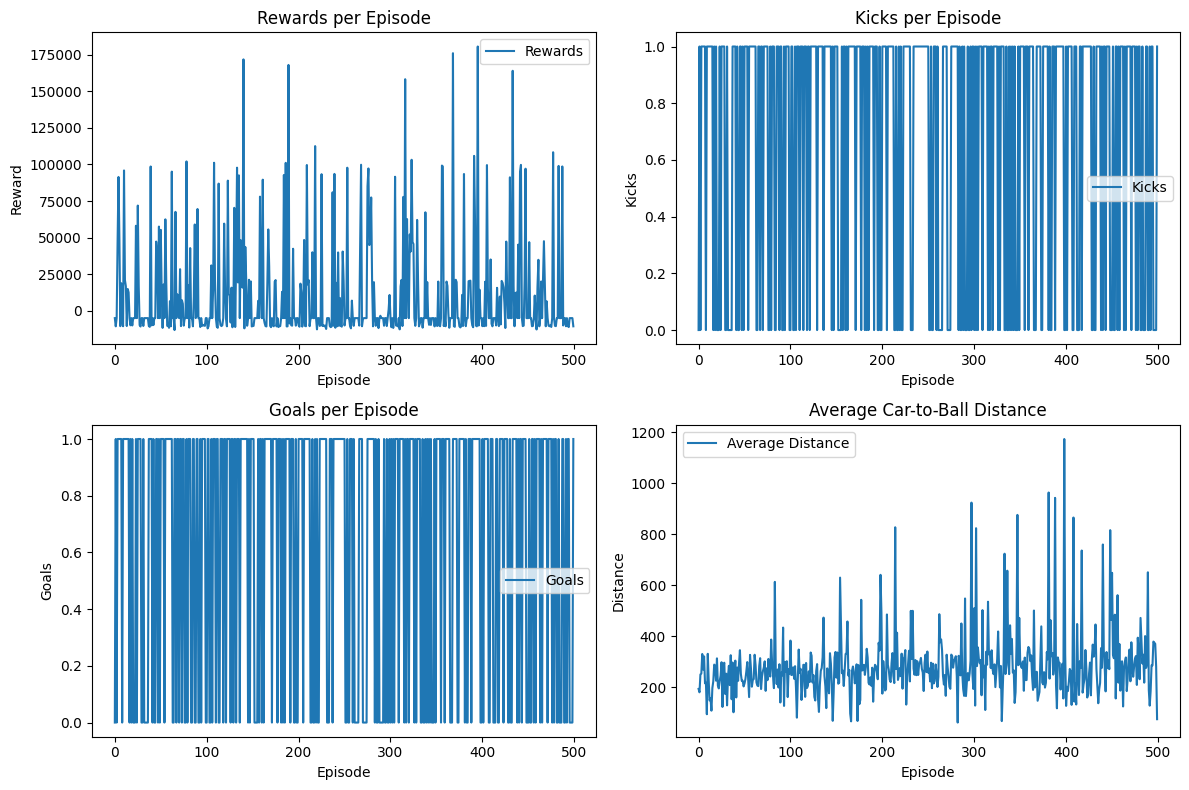

In [ ]:
if __name__ == "__main__":
    train_dqn(episodes=500)
    event = pygame.event.get()
    if event.type == pygame.QUIT:
        pygame.quit()
        raise SystemExit

In [6]:
for event in pygame.event.get():
    if event.type == pygame.QUIT:
        pygame.quit()
        raise SystemExit

SystemExit: 

C:\Users\sakth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
